<a href="https://colab.research.google.com/github/deepjyotisaha85/eva4/blob/master/session6/Solution_EVA4S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
dropout_value = 0.15
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            #nn.Dropout(dropout_value),
        ) # output_size = 26, receptive field: 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            #nn.Dropout(dropout_value),
        ) # output_size = 24, , receptive field: 5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
        ) # output_size = 22, receptive field: 7

        # TRANSITION BLOCK 1
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 22, receptive field: 7

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11, receptive field: 8

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
        ) # output_size = 9, receptive field: 12

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 7, receptive field: 16

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 5, receptive field: 20
    
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1, receptive field: 28

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1, receptive field: 28

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1, receptive field: 28

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1, receptive field: 28

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x) 
        x = self.convblock8(x)       
        x = self.convblock9(x)
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]             900
              ReLU-5           [-1, 10, 24, 24]               0
       BatchNorm2d-6           [-1, 10, 24, 24]              20
            Conv2d-7           [-1, 20, 22, 22]           1,800
              ReLU-8           [-1, 20, 22, 22]               0
       BatchNorm2d-9           [-1, 20, 22, 22]              40
          Dropout-10           [-1, 20, 22, 22]               0
           Conv2d-11           [-1, 10, 22, 22]             200
        MaxPool2d-12           [-1, 10, 11, 11]               0
           Conv2d-13             [-1, 10, 9, 9]             900
             ReLU-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [8]:
from torch.optim.lr_scheduler import StepLR


model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

# Case 1: Training for 40 Epocs 
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.1296718716621399 Batch_id=468 Accuracy=77.17: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1086, Accuracy: 9654/10000 (96.54%)

EPOCH: 1


Loss=0.10248135775327682 Batch_id=468 Accuracy=96.26: 100%|██████████| 469/469 [00:13<00:00, 35.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0635, Accuracy: 9814/10000 (98.14%)

EPOCH: 2


Loss=0.18964047729969025 Batch_id=468 Accuracy=97.06: 100%|██████████| 469/469 [00:13<00:00, 34.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9875/10000 (98.75%)

EPOCH: 3


Loss=0.04700610414147377 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:13<00:00, 35.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9889/10000 (98.89%)

EPOCH: 4


Loss=0.06179952621459961 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:13<00:00, 35.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9876/10000 (98.76%)

EPOCH: 5


Loss=0.021131983026862144 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:13<00:00, 34.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9915/10000 (99.15%)

EPOCH: 6


Loss=0.10669028759002686 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:13<00:00, 35.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9910/10000 (99.10%)

EPOCH: 7


Loss=0.1294177621603012 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.07762335985898972 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:13<00:00, 34.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9920/10000 (99.20%)

EPOCH: 9


Loss=0.016665538772940636 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:13<00:00, 35.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.029451126232743263 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:13<00:00, 34.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.028468355536460876 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:13<00:00, 35.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9915/10000 (99.15%)

EPOCH: 12


Loss=0.07192998379468918 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:13<00:00, 34.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.01248176395893097 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:13<00:00, 35.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9943/10000 (99.43%)

EPOCH: 14


Loss=0.013341079466044903 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:13<00:00, 33.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)

EPOCH: 15


Loss=0.012608830817043781 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 34.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9925/10000 (99.25%)

EPOCH: 16


Loss=0.059206973761320114 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 34.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9942/10000 (99.42%)

EPOCH: 17


Loss=0.013610243797302246 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:13<00:00, 34.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9934/10000 (99.34%)

EPOCH: 18


Loss=0.08390317112207413 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:13<00:00, 34.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9935/10000 (99.35%)

EPOCH: 19


Loss=0.04193231090903282 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 33.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9932/10000 (99.32%)

EPOCH: 20


Loss=0.008327697403728962 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 34.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9940/10000 (99.40%)

EPOCH: 21


Loss=0.02635759674012661 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:13<00:00, 34.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9945/10000 (99.45%)

EPOCH: 22


Loss=0.0849728062748909 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:13<00:00, 34.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9936/10000 (99.36%)

EPOCH: 23


Loss=0.010379090905189514 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 34.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9943/10000 (99.43%)

EPOCH: 24


Loss=0.00606931746006012 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:14<00:00, 33.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9940/10000 (99.40%)

EPOCH: 25


Loss=0.08288663625717163 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 34.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9938/10000 (99.38%)

EPOCH: 26


Loss=0.01889590360224247 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:14<00:00, 33.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)

EPOCH: 27


Loss=0.06178230419754982 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 43.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9937/10000 (99.37%)

EPOCH: 28


Loss=0.039061255753040314 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 32.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9942/10000 (99.42%)

EPOCH: 29


Loss=0.0332699678838253 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 33.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9946/10000 (99.46%)

EPOCH: 30


Loss=0.09282835572957993 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 32.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9956/10000 (99.56%)

EPOCH: 31


Loss=0.01791774295270443 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:13<00:00, 33.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9947/10000 (99.47%)

EPOCH: 32


Loss=0.010313421487808228 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 33.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9947/10000 (99.47%)

EPOCH: 33


Loss=0.013960178010165691 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9935/10000 (99.35%)

EPOCH: 34


Loss=0.005755285266786814 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:14<00:00, 32.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9943/10000 (99.43%)

EPOCH: 35


Loss=0.02258102037012577 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:14<00:00, 33.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9950/10000 (99.50%)

EPOCH: 36


Loss=0.020440826192498207 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:14<00:00, 38.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9937/10000 (99.37%)

EPOCH: 37


Loss=0.06452183425426483 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 32.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9947/10000 (99.47%)

EPOCH: 38


Loss=0.028690123930573463 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 38.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9947/10000 (99.47%)

EPOCH: 39


Loss=0.017012277618050575 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 32.35it/s]



Test set: Average loss: 0.0172, Accuracy: 9954/10000 (99.54%)



In [15]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
PATH = '/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/model-40-epoch.pt'
torch.save(model, PATH)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


================= Case 1: 40 Epocs ===============


Text(0.5, 1.0, 'Test Accuracy')

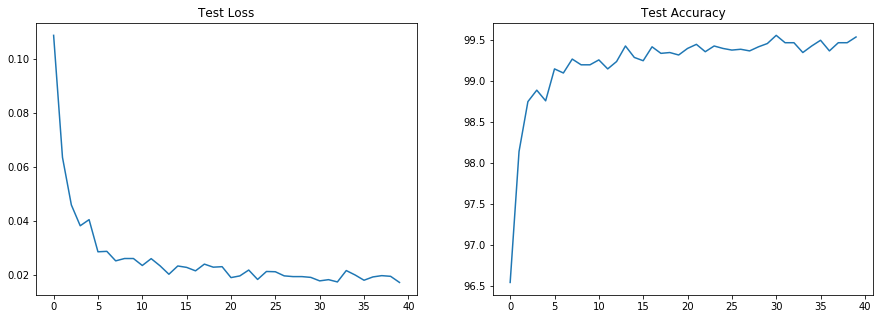

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
print("================= Case 1: 40 Epocs ===============")
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(test_losses)
axs[0].set_title("Test Loss")
axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")
plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/no-l1-l2-figure.png", bbox_inches='tight')

In [0]:
def l1_train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for parameter in model.parameters():
      reg_loss += l1_crit(parameter, loss)
    factor = 0.00025
    loss += factor * reg_loss

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


In [0]:
from torch.optim.lr_scheduler import StepLR


model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


In [14]:
# Case 2: Training for 40 Epocs with L1
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    l1_train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([10, 1, 3, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([])


Test set: Average loss: 0.0639, Accuracy: 9806/10000 (98.06%)

EPOCH: 1


Loss=0.34935295581817627 Batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:16<00:00, 29.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0573, Accuracy: 9823/10000 (98.23%)

EPOCH: 2


Loss=0.7749996781349182 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:15<00:00, 29.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9893/10000 (98.93%)

EPOCH: 3


Loss=0.2583393454551697 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:16<00:00, 37.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Accuracy: 9858/10000 (98.58%)

EPOCH: 4


Loss=0.30950069427490234 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:15<00:00, 29.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9857/10000 (98.57%)

EPOCH: 5


Loss=0.2511414587497711 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:16<00:00, 28.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9906/10000 (99.06%)

EPOCH: 6


Loss=0.3531345725059509 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:15<00:00, 29.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9900/10000 (99.00%)

EPOCH: 7


Loss=0.31716492772102356 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:16<00:00, 28.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9895/10000 (98.95%)

EPOCH: 8


Loss=0.24743129312992096 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:16<00:00, 28.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9895/10000 (98.95%)

EPOCH: 9


Loss=0.24360787868499756 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:16<00:00, 28.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9895/10000 (98.95%)

EPOCH: 10


Loss=0.2517051100730896 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:16<00:00, 34.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9900/10000 (99.00%)

EPOCH: 11


Loss=0.33667802810668945 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:16<00:00, 28.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9912/10000 (99.12%)

EPOCH: 12


Loss=0.2778286337852478 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:17<00:00, 27.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9932/10000 (99.32%)

EPOCH: 13


Loss=0.20667767524719238 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:17<00:00, 29.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9894/10000 (98.94%)

EPOCH: 14


Loss=0.20785266160964966 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:17<00:00, 27.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9901/10000 (99.01%)

EPOCH: 15


Loss=0.23601272702217102 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:17<00:00, 26.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9866/10000 (98.66%)

EPOCH: 16


Loss=0.2396399974822998 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:17<00:00, 26.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9894/10000 (98.94%)

EPOCH: 17


Loss=0.35500043630599976 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:17<00:00, 26.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9925/10000 (99.25%)

EPOCH: 18


Loss=0.26108404994010925 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:19<00:00, 24.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9911/10000 (99.11%)

EPOCH: 19


Loss=0.20792360603809357 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:19<00:00, 24.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9896/10000 (98.96%)

EPOCH: 20


Loss=0.20797009766101837 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:18<00:00, 24.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9915/10000 (99.15%)

EPOCH: 21


Loss=0.19749203324317932 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:19<00:00, 24.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9915/10000 (99.15%)

EPOCH: 22


Loss=0.2801385819911957 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:19<00:00, 23.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9851/10000 (98.51%)

EPOCH: 23


Loss=0.20075483620166779 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:18<00:00, 24.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9908/10000 (99.08%)

EPOCH: 24


Loss=0.43853968381881714 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:19<00:00, 24.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9874/10000 (98.74%)

EPOCH: 25


Loss=0.21321886777877808 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:19<00:00, 31.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9909/10000 (99.09%)

EPOCH: 26


Loss=0.19752395153045654 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:18<00:00, 25.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9912/10000 (99.12%)

EPOCH: 27


Loss=0.22655873000621796 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:17<00:00, 26.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9911/10000 (99.11%)

EPOCH: 28


Loss=0.20651724934577942 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:18<00:00, 26.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9909/10000 (99.09%)

EPOCH: 29


Loss=0.21237455308437347 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:18<00:00, 33.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9890/10000 (98.90%)

EPOCH: 30


Loss=0.30164432525634766 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:18<00:00, 33.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9889/10000 (98.89%)

EPOCH: 31


Loss=0.1933770477771759 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:18<00:00, 25.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9909/10000 (99.09%)

EPOCH: 32


Loss=0.18760818243026733 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:17<00:00, 26.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9903/10000 (99.03%)

EPOCH: 33


Loss=0.19450820982456207 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:17<00:00, 26.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9896/10000 (98.96%)

EPOCH: 34


Loss=0.19010621309280396 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:17<00:00, 26.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9915/10000 (99.15%)

EPOCH: 35


Loss=0.34155017137527466 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:17<00:00, 27.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9918/10000 (99.18%)

EPOCH: 36


Loss=0.22305160760879517 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:17<00:00, 33.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9898/10000 (98.98%)

EPOCH: 37


Loss=0.30593812465667725 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:18<00:00, 26.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9927/10000 (99.27%)

EPOCH: 38


Loss=0.20078067481517792 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:17<00:00, 33.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9906/10000 (99.06%)

EPOCH: 39


Loss=0.18220163881778717 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:17<00:00, 26.88it/s]



Test set: Average loss: 0.0322, Accuracy: 9912/10000 (99.12%)



In [16]:
PATH = '/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/model-l1-40-epoch.pt'
torch.save(model, PATH)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


================= Case 2: L1 40 Epocs ===============


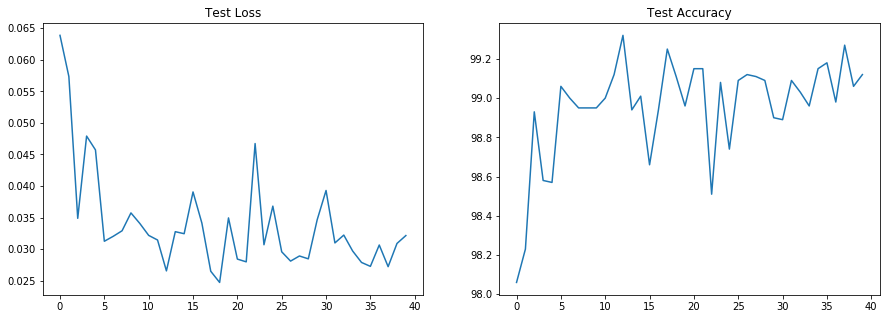

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
print("================= Case 2: L1 40 Epocs ===============")
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(test_losses)
axs[0].set_title("Test Loss")
axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")
plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l1-figure.png", bbox_inches='tight')

In [40]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-5, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

# Case 3: Training for 40 Epocs with l2
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.0867399200797081 Batch_id=468 Accuracy=76.73: 100%|██████████| 469/469 [00:14<00:00, 31.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1442, Accuracy: 9579/10000 (95.79%)

EPOCH: 1


Loss=0.14814065396785736 Batch_id=468 Accuracy=96.40: 100%|██████████| 469/469 [00:14<00:00, 32.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0708, Accuracy: 9789/10000 (97.89%)

EPOCH: 2


Loss=0.150431826710701 Batch_id=468 Accuracy=97.15: 100%|██████████| 469/469 [00:16<00:00, 28.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0544, Accuracy: 9847/10000 (98.47%)

EPOCH: 3


Loss=0.03759005665779114 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:16<00:00, 28.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9888/10000 (98.88%)

EPOCH: 4


Loss=0.11509805917739868 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:16<00:00, 28.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9878/10000 (98.78%)

EPOCH: 5


Loss=0.014661435969173908 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:15<00:00, 29.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.13805057108402252 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:15<00:00, 30.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9901/10000 (99.01%)

EPOCH: 7


Loss=0.063570536673069 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:15<00:00, 30.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9911/10000 (99.11%)

EPOCH: 8


Loss=0.01877537928521633 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:14<00:00, 31.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9909/10000 (99.09%)

EPOCH: 9


Loss=0.021890461444854736 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:15<00:00, 30.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.01663646101951599 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:15<00:00, 31.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9901/10000 (99.01%)

EPOCH: 11


Loss=0.012058367021381855 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:14<00:00, 31.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=0.020354464650154114 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:14<00:00, 31.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9908/10000 (99.08%)

EPOCH: 13


Loss=0.08975633233785629 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:14<00:00, 37.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9914/10000 (99.14%)

EPOCH: 14


Loss=0.008775671012699604 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:14<00:00, 31.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9928/10000 (99.28%)

EPOCH: 15


Loss=0.07113642245531082 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 31.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9921/10000 (99.21%)

EPOCH: 16


Loss=0.04371822252869606 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:15<00:00, 30.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9928/10000 (99.28%)

EPOCH: 17


Loss=0.06938106566667557 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:14<00:00, 31.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9923/10000 (99.23%)

EPOCH: 18


Loss=0.012564539909362793 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:14<00:00, 31.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9934/10000 (99.34%)

EPOCH: 19


Loss=0.021066689863801003 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:15<00:00, 30.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9927/10000 (99.27%)

EPOCH: 20


Loss=0.00969927478581667 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:14<00:00, 31.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9926/10000 (99.26%)

EPOCH: 21


Loss=0.04541223123669624 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 31.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9937/10000 (99.37%)

EPOCH: 22


Loss=0.057620782405138016 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:14<00:00, 32.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9929/10000 (99.29%)

EPOCH: 23


Loss=0.044662956148386 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:15<00:00, 30.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9931/10000 (99.31%)

EPOCH: 24


Loss=0.01277419924736023 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 31.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9931/10000 (99.31%)

EPOCH: 25


Loss=0.03360843285918236 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9929/10000 (99.29%)

EPOCH: 26


Loss=0.01347364205867052 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:16<00:00, 28.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9939/10000 (99.39%)

EPOCH: 27


Loss=0.0062470934353768826 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:16<00:00, 27.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9943/10000 (99.43%)

EPOCH: 28


Loss=0.05254781246185303 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:17<00:00, 27.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9930/10000 (99.30%)

EPOCH: 29


Loss=0.012996275909245014 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:16<00:00, 28.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9932/10000 (99.32%)

EPOCH: 30


Loss=0.02541308104991913 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9933/10000 (99.33%)

EPOCH: 31


Loss=0.08805704116821289 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:16<00:00, 27.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9928/10000 (99.28%)

EPOCH: 32


Loss=0.04850004240870476 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:15<00:00, 30.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9937/10000 (99.37%)

EPOCH: 33


Loss=0.016428330913186073 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:16<00:00, 34.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9940/10000 (99.40%)

EPOCH: 34


Loss=0.011732101440429688 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:16<00:00, 29.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9932/10000 (99.32%)

EPOCH: 35


Loss=0.015962965786457062 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:15<00:00, 36.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9925/10000 (99.25%)

EPOCH: 36


Loss=0.12792938947677612 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:15<00:00, 29.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

EPOCH: 37


Loss=0.007324045058339834 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9936/10000 (99.36%)

EPOCH: 38


Loss=0.043976519256830215 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:15<00:00, 30.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9932/10000 (99.32%)

EPOCH: 39


Loss=0.004578968044370413 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:15<00:00, 39.67it/s]



Test set: Average loss: 0.0223, Accuracy: 9933/10000 (99.33%)



================= Case 2: L1 40 Epocs ===============


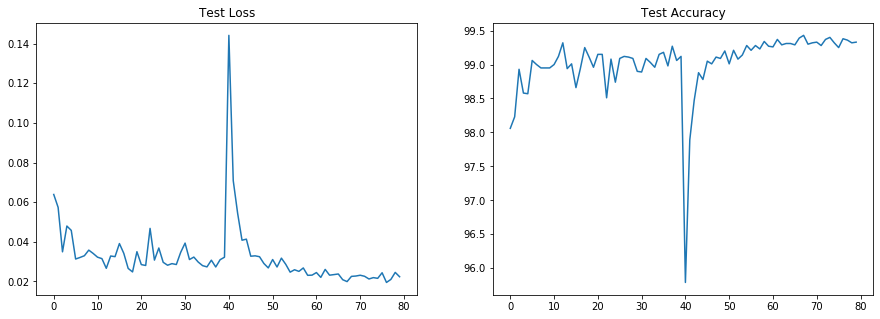

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
print("================= Case 2: L1 40 Epocs ===============")
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(test_losses)
axs[0].set_title("Test Loss")
axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")
plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')

In [42]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-5, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

# Case 4: Training for 40 Epocs with L1 and L2
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    l1_train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([10, 1, 3, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([])


Test set: Average loss: 0.0746, Accuracy: 9774/10000 (97.74%)

EPOCH: 1


Loss=0.4262672960758209 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:18<00:00, 25.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9858/10000 (98.58%)

EPOCH: 2


Loss=0.40369635820388794 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:18<00:00, 26.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9890/10000 (98.90%)

EPOCH: 3


Loss=0.31574442982673645 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:17<00:00, 26.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9887/10000 (98.87%)

EPOCH: 4


Loss=0.34962400794029236 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:17<00:00, 26.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9862/10000 (98.62%)

EPOCH: 5


Loss=0.29739171266555786 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:18<00:00, 25.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9871/10000 (98.71%)

EPOCH: 6


Loss=0.3421945571899414 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:17<00:00, 26.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 9861/10000 (98.61%)

EPOCH: 7


Loss=0.23024292290210724 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:17<00:00, 26.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9896/10000 (98.96%)

EPOCH: 8


Loss=0.2085975855588913 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:17<00:00, 26.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9897/10000 (98.97%)

EPOCH: 9


Loss=0.21035240590572357 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:17<00:00, 33.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9906/10000 (99.06%)

EPOCH: 10


Loss=0.46399179100990295 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:18<00:00, 29.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9886/10000 (98.86%)

EPOCH: 11


Loss=0.22525833547115326 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:18<00:00, 24.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Accuracy: 9887/10000 (98.87%)

EPOCH: 12


Loss=0.2330022156238556 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:17<00:00, 26.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9880/10000 (98.80%)

EPOCH: 13


Loss=0.20932026207447052 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:17<00:00, 27.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9897/10000 (98.97%)

EPOCH: 14


Loss=0.20937712490558624 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:17<00:00, 26.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9888/10000 (98.88%)

EPOCH: 15


Loss=0.19979611039161682 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:17<00:00, 26.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9914/10000 (99.14%)

EPOCH: 16


Loss=0.2470611333847046 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:18<00:00, 31.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9910/10000 (99.10%)

EPOCH: 17


Loss=0.29919567704200745 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:19<00:00, 24.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9879/10000 (98.79%)

EPOCH: 18


Loss=0.23458285629749298 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:19<00:00, 24.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9889/10000 (98.89%)

EPOCH: 19


Loss=0.2142426073551178 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:17<00:00, 26.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9887/10000 (98.87%)

EPOCH: 20


Loss=0.20927487313747406 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:17<00:00, 26.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9867/10000 (98.67%)

EPOCH: 21


Loss=0.31522345542907715 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:17<00:00, 31.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9881/10000 (98.81%)

EPOCH: 22


Loss=0.21202702820301056 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:17<00:00, 26.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9904/10000 (99.04%)

EPOCH: 23


Loss=0.23838025331497192 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:18<00:00, 35.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9915/10000 (99.15%)

EPOCH: 24


Loss=0.38987115025520325 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:17<00:00, 26.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9904/10000 (99.04%)

EPOCH: 25


Loss=0.19016198813915253 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:17<00:00, 26.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9899/10000 (98.99%)

EPOCH: 26


Loss=0.28978484869003296 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:17<00:00, 26.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9898/10000 (98.98%)

EPOCH: 27


Loss=0.3438662588596344 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:17<00:00, 26.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9907/10000 (99.07%)

EPOCH: 28


Loss=0.388511598110199 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:18<00:00, 25.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 9867/10000 (98.67%)

EPOCH: 29


Loss=0.1880488395690918 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:18<00:00, 25.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9915/10000 (99.15%)

EPOCH: 30


Loss=0.2957336902618408 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:18<00:00, 25.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9867/10000 (98.67%)

EPOCH: 31


Loss=0.2111283540725708 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:17<00:00, 26.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 9893/10000 (98.93%)

EPOCH: 32


Loss=0.1954272836446762 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:18<00:00, 25.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9890/10000 (98.90%)

EPOCH: 33


Loss=0.18679337203502655 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:17<00:00, 26.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9870/10000 (98.70%)

EPOCH: 34


Loss=0.19288980960845947 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:18<00:00, 30.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9887/10000 (98.87%)

EPOCH: 35


Loss=0.20869575440883636 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:19<00:00, 23.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9900/10000 (99.00%)

EPOCH: 36


Loss=0.33217912912368774 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:19<00:00, 23.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9887/10000 (98.87%)

EPOCH: 37


Loss=0.19168536365032196 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:17<00:00, 26.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9900/10000 (99.00%)

EPOCH: 38


Loss=0.20007282495498657 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:19<00:00, 24.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9864/10000 (98.64%)

EPOCH: 39


Loss=0.7452004551887512 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:17<00:00, 26.07it/s]



Test set: Average loss: 0.0293, Accuracy: 9909/10000 (99.09%)



================= Case 4: L1 40 Epocs ===============


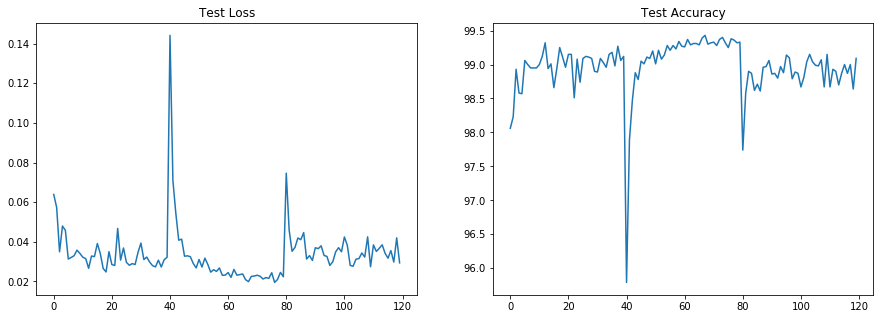

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
print("================= Case 4: L1 40 Epocs ===============")
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(test_losses)
axs[0].set_title("Test Loss")
axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")
plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l1-l2-figure.png", bbox_inches='tight')